In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random

from scipy.io import loadmat
from matplotlib.ticker import MaxNLocator

In [2]:
# Define fonts and fontsize for plotting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
fontsize = 15
fontsize_ticks = 12

In [3]:
# Define necessary functions
# Function to get displacement and void data
def get_data(file_directory, void_number):

    # Load the displacement data
    test_displacement_data = loadmat(os.path.join(file_directory, f'void_{void_number}_test_displacement_data_normalized.mat'))['displacement_data']
   
    # Load the void data
    test_void_data = loadmat(os.path.join(file_directory, f'void_{void_number}_test_void_data.mat'))['void_data']
    
    return test_displacement_data, test_void_data

In [4]:
# Function to calculate metrics
def metrics_calculator(target, predicted):

    # True positive
    tp = 0

    # True negative
    tn = 0

    # False positive
    fp = 0

    # False negative
    fn = 0

    # Lists to store accuracy, precision, and recall
    accuracy = []
    precision = []
    recall = []

    for n_sample in range(target.shape[0]):

        for n_element in range(target.shape[1]):
            
            # If both the target and predicted are same
            if target[n_sample, n_element] == predicted[n_sample, n_element]:

                # If the target and predicted are both 1
                if target[n_sample, n_element] == 1 and predicted[n_sample, n_element] == 1:

                    tp = tp + 1

                # If the target and predicted are both 0
                elif target[n_sample, n_element] == 0 and predicted[n_sample, n_element] == 0:

                    tn = tn + 1
            
            # If the target and predicted are different
            else:

                # If the target is 0 and predicted is 1
                if target[n_sample, n_element] == 0 and predicted[n_sample, n_element] == 1:

                    fp = fp + 1
                
                # If the target is 1 and predicted is 0
                elif target[n_sample, n_element] == 1 and predicted[n_sample, n_element] == 0:
                
                    fn = fn + 1
            
        # Calculate accuracy, precision, and recall
        accuracy.append((tp + tn) / (tp + tn + fp + fn))
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    
    # Convert the lists to numpy arrays
    accuracy = np.array(accuracy)
    precision = np.array(precision)
    recall = np.array(recall)

    # Calculate the F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

In [5]:
# Function to plot void 0 prediction
def plot_void(target, predicted, file_directory, sample_num, f1_score, void, keyword):

    # See how the actual void looks in target
    actual_plot = plt.figure()
    ax = plt.axes()
    im1 = plt.imshow(target[sample_num, :, :], cmap='binary', origin='lower', vmin=0, vmax=1, extent=[0, 50, 0, 50])
    
    # Domain section lines
    plt.axhline(y=10, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
    plt.axhline(y=20, color='k', linewidth = 0.5)
    plt.axhline(y=30, color='k', linewidth = 0.5)
    plt.axhline(y=40, color='k', linewidth = 0.5)

    plt.axvline(x=5, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
    plt.axvline(x=45, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
    
    plt.xlabel('$x$ [m]', fontsize=fontsize)
    plt.ylabel('$y$ [m]', fontsize=fontsize)

    plt.title(f'Sample Number: {sample_num+1}', fontsize=fontsize_ticks)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    cax = actual_plot.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cb = plt.colorbar(im1, cax=cax)
    cb.ax.tick_params(labelsize=fontsize_ticks)
    plt.savefig(os.path.join(file_directory, f'{keyword}_void_{void}_target.pdf'), bbox_inches='tight')

    # See how the predicted void looks in prediction
    predicted_plot = plt.figure()
    ax = plt.axes()
    im2 = plt.imshow(predicted[sample_num, :], cmap='binary', origin='lower', vmin=0, vmax=1, extent=[0, 50, 0, 50])
    
    # Domain section lines
    plt.axhline(y=10, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
    plt.axhline(y=20, color='k', linewidth = 0.5)
    plt.axhline(y=30, color='k', linewidth = 0.5)
    plt.axhline(y=40, color='k', linewidth = 0.5)

    plt.axvline(x=5, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
    plt.axvline(x=45, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))

    plt.xlabel('$x$ [m]', fontsize=fontsize)
    plt.ylabel('$y$ [m]', fontsize=fontsize)

    plt.title(f'Sample Number: {sample_num+1}; F1 score: {f1_score*100:.2f}%', fontsize=fontsize_ticks)    
    ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
    cax = predicted_plot.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cb = plt.colorbar(im2, cax=cax)
    cb.ax.tick_params(labelsize=fontsize_ticks)
    plt.savefig(os.path.join(file_directory, f'{keyword}_void_{void}_predicted.pdf'), bbox_inches='tight')

    return actual_plot, predicted_plot

In [6]:
# Define directories
current_directory = os.getcwd()

# Define directory for the normalized data
normalized_data_directory = os.path.join(current_directory, '..', '..', 'data', 'normalized')

# Define directory for the trained results
trained_results_directory = os.path.join(current_directory, '..', '..', 'cnn', 'training_results')

# Define directory for the prediction results
prediction_results_directory = os.path.join(current_directory, '..', '..', 'cnn', 'prediction_results', 'test')

In [7]:
# Get the normalized data for all three voids
void = 2
void_test_displacement_data, void_target_void_data = get_data(normalized_data_directory, void)

In [8]:
# Load the trained model
# model = tf.keras.models.load_model(os.path.join(trained_results_directory, 'best_model.h5'))
model = tf.keras.models.load_model(os.path.join(trained_results_directory, 'model.h5'))

2024-11-16 17:55:07.836544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-16 17:55:07.842061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-16 17:55:07.842203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-16 17:55:07.842648: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
# Use the model to predict on the test data both probability and class
threshold = 0.5
void_predicted_void_data_probabilistic = model.predict(void_test_displacement_data)
void_predicted_void_data_class = np.where(void_predicted_void_data_probabilistic > threshold, 1, 0)

2024-11-16 17:55:09.540766: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-11-16 17:55:09.821499: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


In [10]:
# Plot the void prediction
if void != 0:

    # Calculate the metrics
    accuracy, precision, recall, f1_score = metrics_calculator(void_target_void_data, void_predicted_void_data_class)

    # Check where the f1 score is minimum and maximum
    # If multiple, then pick the first one
    min_f1_score_location = np.argmin(f1_score)
    max_f1_score_location = np.argmax(f1_score)

In [11]:
# Reshape the target and predicted data to a 50x50 grid
void_target_void_data = np.reshape(void_target_void_data, (void_target_void_data.shape[0], 50, 50))
void_predicted_void_data_probabilistic = np.reshape(void_predicted_void_data_probabilistic, (void_predicted_void_data_probabilistic.shape[0], 50, 50))

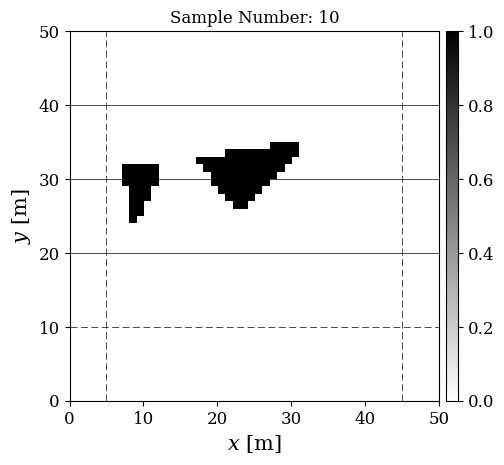

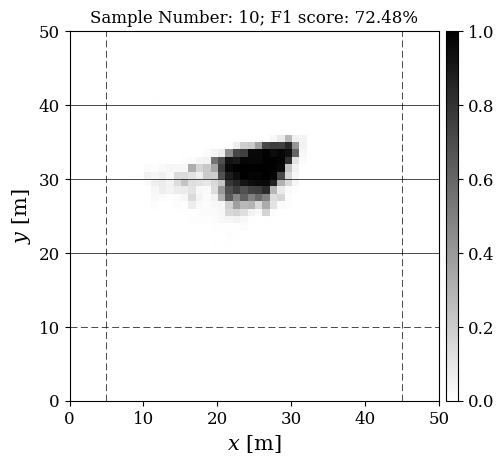

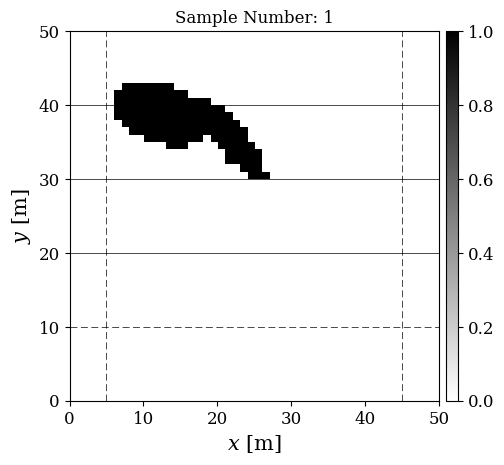

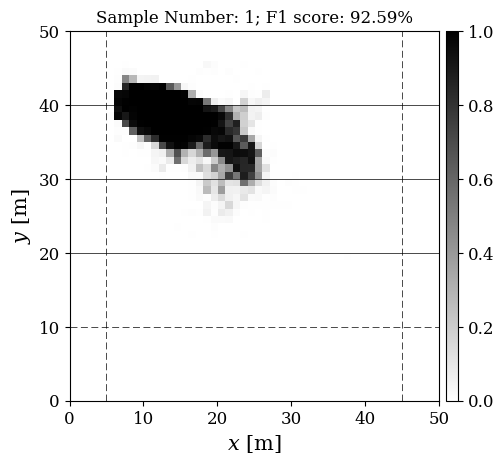

In [12]:
# Plot the void prediction
if void != 0:

    # Minimum f1 score plot
    actual_plot, predicted_plot = plot_void(void_target_void_data, void_predicted_void_data_probabilistic, prediction_results_directory, min_f1_score_location, f1_score[min_f1_score_location], void, 'worst', )

    # Maximum f1 score plot
    actual_plot, predicted_plot = plot_void(void_target_void_data, void_predicted_void_data_probabilistic, prediction_results_directory, max_f1_score_location, f1_score[max_f1_score_location], void, 'best')

else:

    # Plot the void prediction
    actual_plot, predicted_plot = plot_void(void_target_void_data, void_predicted_void_data_probabilistic, prediction_results_directory, random.randint(0, void_target_void_data.shape[0]), 1, void, '')